In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [2]:
# Simple sequence data
# Input sequences of length 3, predict the next value
# Pattern: each sequence is consecutive numbers

# Sequence 1: [1, 2, 3] → 4
# Sequence 2: [2, 3, 4] → 5
# Sequence 3: [3, 4, 5] → 6
# Sequence 4: [4, 5, 6] → 7

# Normalize to [0, 1] range for easier training
X_sequences = torch.tensor([
    [[0.1], [0.2], [0.3]],  # Sequence 1: 3 time steps, 1 feature each
    [[0.2], [0.3], [0.4]],  # Sequence 2
    [[0.3], [0.4], [0.5]],  # Sequence 3
    [[0.4], [0.5], [0.6]],  # Sequence 4
], dtype=torch.float32)

y_targets = torch.tensor([
    [0.4],  # Target for sequence 1
    [0.5],  # Target for sequence 2
    [0.6],  # Target for sequence 3
    [0.7],  # Target for sequence 4
], dtype=torch.float32)

print("Input sequences shape:", X_sequences.shape)  # (batch, seq_len, features)
print("Target shape:", y_targets.shape)

print("\nTraining Data:")
for i in range(len(X_sequences)):
    seq = [x.item() for x in X_sequences[i]]
    target = y_targets[i].item()
    print(f"  Sequence {i+1}: {seq} → {target}")

Input sequences shape: torch.Size([4, 3, 1])
Target shape: torch.Size([4, 1])

Training Data:
  Sequence 1: [0.10000000149011612, 0.20000000298023224, 0.30000001192092896] → 0.4000000059604645
  Sequence 2: [0.20000000298023224, 0.30000001192092896, 0.4000000059604645] → 0.5
  Sequence 3: [0.30000001192092896, 0.4000000059604645, 0.5] → 0.6000000238418579
  Sequence 4: [0.4000000059604645, 0.5, 0.6000000238418579] → 0.699999988079071


In [3]:
# RNN Parameters
input_size = 1    # Each time step has 1 feature
hidden_size = 4   # Hidden state dimension
output_size = 1   # Predict 1 value

# Initialize weights with Xavier initialization
def init_weights():
    # Input to hidden weights
    W_xh = torch.randn(input_size, hidden_size) * np.sqrt(2.0 / input_size)
    
    # Hidden to hidden weights
    W_hh = torch.randn(hidden_size, hidden_size) * np.sqrt(2.0 / hidden_size)
    
    # Hidden bias
    b_h = torch.zeros(1, hidden_size)
    
    # Hidden to output weights
    W_hy = torch.randn(hidden_size, output_size) * np.sqrt(2.0 / hidden_size)
    
    # Output bias
    b_y = torch.zeros(1, output_size)
    
    return W_xh, W_hh, b_h, W_hy, b_y

W_xh, W_hh, b_h, W_hy, b_y = init_weights()

print("RNN Weights:")
print(f"W_xh (input→hidden): {W_xh.shape}")
print(f"W_hh (hidden→hidden): {W_hh.shape}")
print(f"b_h: {b_h.shape}")
print(f"W_hy (hidden→output): {W_hy.shape}")
print(f"b_y: {b_y.shape}")

RNN Weights:
W_xh (input→hidden): torch.Size([1, 4])
W_hh (hidden→hidden): torch.Size([4, 4])
b_h: torch.Size([1, 4])
W_hy (hidden→output): torch.Size([4, 1])
b_y: torch.Size([1, 1])


In [4]:
def tanh(x):
    """Tanh activation function"""
    return torch.tanh(x)

def tanh_derivative(x):
    """Derivative of tanh: 1 - tanh(x)^2"""
    return 1 - torch.tanh(x) ** 2

# Test
test_x = torch.tensor([-1.0, 0.0, 1.0])
print("tanh test:")
print(f"  Input: {test_x.tolist()}")
print(f"  tanh: {tanh(test_x).tolist()}")
print(f"  tanh': {tanh_derivative(test_x).tolist()}")

tanh test:
  Input: [-1.0, 0.0, 1.0]
  tanh: [-0.7615941762924194, 0.0, 0.7615941762924194]
  tanh': [0.41997432708740234, 1.0, 0.41997432708740234]


In [5]:
def rnn_forward(X_seq, W_xh, W_hh, b_h, W_hy, b_y, h_prev=None):
    """
    Forward pass through RNN for a single sequence.
    
    Args:
        X_seq: Input sequence (seq_len, input_size)
        W_xh, W_hh, b_h: RNN cell weights
        W_hy, b_y: Output layer weights
        h_prev: Previous hidden state (optional)
    
    Returns:
        y_pred: Final output
        hidden_states: All hidden states
        pre_activations: Pre-activation values (for backprop)
    """
    seq_len = X_seq.shape[0]
    
    # Initialize hidden state if not provided
    if h_prev is None:
        h_prev = torch.zeros(1, hidden_size)
    
    # Store all hidden states and pre-activations for backprop
    hidden_states = [h_prev]
    pre_activations = []
    
    # Process each time step
    h_t = h_prev
    for t in range(seq_len):
        x_t = X_seq[t].unsqueeze(0)  # (1, input_size)
        
        # RNN cell computation
        # z_t = x_t @ W_xh + h_{t-1} @ W_hh + b_h
        z_t = torch.matmul(x_t, W_xh) + torch.matmul(h_t, W_hh) + b_h
        pre_activations.append(z_t)
        
        # h_t = tanh(z_t)
        h_t = tanh(z_t)
        hidden_states.append(h_t)
    
    # Output layer (using final hidden state)
    y_pred = torch.matmul(h_t, W_hy) + b_y
    
    return y_pred, hidden_states, pre_activations

# Test forward pass on first sequence
print("Testing forward pass on first sequence:")
y_pred, hidden_states, pre_acts = rnn_forward(X_sequences[0], W_xh, W_hh, b_h, W_hy, b_y)
print(f"Input sequence: {[x.item() for x in X_sequences[0]]}")
print(f"Predicted output: {y_pred.item():.4f}")
print(f"Target: {y_targets[0].item()}")
print(f"Number of hidden states: {len(hidden_states)}")

Testing forward pass on first sequence:
Input sequence: [0.10000000149011612, 0.20000000298023224, 0.30000001192092896]
Predicted output: -0.0882
Target: 0.4000000059604645
Number of hidden states: 4


In [6]:
def rnn_forward_verbose(X_seq, W_xh, W_hh, b_h, W_hy, b_y):
    """Forward pass with detailed output for understanding."""
    
    print("="*60)
    print("RNN FORWARD PASS (Step by Step)")
    print("="*60)
    
    seq_len = X_seq.shape[0]
    h_t = torch.zeros(1, hidden_size)
    
    print(f"\nInitial hidden state h_0: {h_t.flatten().tolist()}")
    
    hidden_states = [h_t]
    pre_activations = []
    
    for t in range(seq_len):
        print(f"\n--- Time Step t={t+1} ---")
        x_t = X_seq[t].unsqueeze(0)
        print(f"Input x_{t+1} = {x_t.flatten().tolist()}")
        print(f"Previous hidden h_{t} = {h_t.flatten().tolist()[:3]}...")
        
        # Compute pre-activation
        term1 = torch.matmul(x_t, W_xh)
        term2 = torch.matmul(h_t, W_hh)
        z_t = term1 + term2 + b_h
        pre_activations.append(z_t)
        
        print(f"z_{t+1} = x_{t+1}·W_xh + h_{t}·W_hh + b_h")
        
        # Apply activation
        h_t = tanh(z_t)
        hidden_states.append(h_t)
        print(f"h_{t+1} = tanh(z_{t+1}) = {h_t.flatten().tolist()[:3]}...")
    
    # Output
    print(f"\n--- Output Layer ---")
    print(f"Using final hidden state h_{seq_len}")
    y_pred = torch.matmul(h_t, W_hy) + b_y
    print(f"y = h_{seq_len}·W_hy + b_y = {y_pred.item():.4f}")
    
    return y_pred, hidden_states, pre_activations

# Run verbose forward pass
y_pred, hidden_states, pre_acts = rnn_forward_verbose(
    X_sequences[0], W_xh, W_hh, b_h, W_hy, b_y
)

RNN FORWARD PASS (Step by Step)

Initial hidden state h_0: [0.0, 0.0, 0.0, 0.0]

--- Time Step t=1 ---
Input x_1 = [0.10000000149011612]
Previous hidden h_0 = [0.0, 0.0, 0.0]...
z_1 = x_1·W_xh + h_0·W_hh + b_h
h_1 = tanh(z_1) = [0.04757925495505333, 0.018214385956525803, 0.03314583748579025]...

--- Time Step t=2 ---
Input x_2 = [0.20000000298023224]
Previous hidden h_1 = [0.04757925495505333, 0.018214385956525803, 0.03314583748579025]...
z_2 = x_2·W_xh + h_1·W_hh + b_h
h_2 = tanh(z_2) = [0.16016122698783875, 0.009915712289512157, 0.14169366657733917]...

--- Time Step t=3 ---
Input x_3 = [0.30000001192092896]
Previous hidden h_2 = [0.16016122698783875, 0.009915712289512157, 0.14169366657733917]...
z_3 = x_3·W_xh + h_2·W_hh + b_h
h_3 = tanh(z_3) = [0.17973896861076355, -0.03306422382593155, 0.2890753448009491]...

--- Output Layer ---
Using final hidden state h_3
y = h_3·W_hy + b_y = -0.0882


In [7]:
def mse_loss(y_true, y_pred):
    """Mean Squared Error loss"""
    return torch.mean((y_true - y_pred) ** 2)

# Test
loss = mse_loss(y_targets[0], y_pred)
print(f"Target: {y_targets[0].item():.4f}")
print(f"Predicted: {y_pred.item():.4f}")
print(f"MSE Loss: {loss.item():.4f}")

Target: 0.4000
Predicted: -0.0882
MSE Loss: 0.2383


In [8]:
def rnn_backward(X_seq, y_true, y_pred, hidden_states, pre_activations,
                 W_xh, W_hh, W_hy):
    """
    Backpropagation Through Time (BPTT).
    
    Returns gradients for all weights.
    """
    seq_len = X_seq.shape[0]
    
    # Initialize gradients
    dW_xh = torch.zeros_like(W_xh)
    dW_hh = torch.zeros_like(W_hh)
    db_h = torch.zeros(1, hidden_size)
    dW_hy = torch.zeros_like(W_hy)
    db_y = torch.zeros(1, output_size)
    
    # Output layer gradient
    # dL/dy = 2(y_pred - y_true) for MSE
    dy = 2 * (y_pred - y_true)
    
    # Gradients for output layer
    # dL/dW_hy = h_T^T @ dy
    h_T = hidden_states[-1]  # Final hidden state
    dW_hy = torch.matmul(h_T.T, dy)
    db_y = dy.clone()
    
    # Gradient flowing to hidden state
    # dL/dh_T = dy @ W_hy^T
    dh_next = torch.matmul(dy, W_hy.T)
    
    # Backpropagate through time
    for t in reversed(range(seq_len)):
        # Get values for this time step
        z_t = pre_activations[t]
        h_prev = hidden_states[t]  # h_{t-1}
        x_t = X_seq[t].unsqueeze(0)
        
        # Gradient through tanh
        # dL/dz_t = dL/dh_t * tanh'(z_t)
        dz = dh_next * tanh_derivative(z_t)
        
        # Accumulate gradients
        # dL/dW_xh += x_t^T @ dz
        dW_xh += torch.matmul(x_t.T, dz)
        
        # dL/dW_hh += h_{t-1}^T @ dz
        dW_hh += torch.matmul(h_prev.T, dz)
        
        # dL/db_h += dz
        db_h += dz
        
        # Gradient to previous hidden state
        # dL/dh_{t-1} = dz @ W_hh^T
        dh_next = torch.matmul(dz, W_hh.T)
    
    return dW_xh, dW_hh, db_h, dW_hy, db_y

# Test backward pass
dW_xh, dW_hh, db_h, dW_hy, db_y = rnn_backward(
    X_sequences[0], y_targets[0:1], y_pred, hidden_states, pre_acts,
    W_xh, W_hh, W_hy
)

print("Gradients computed:")
print(f"dW_xh shape: {dW_xh.shape}")
print(f"dW_hh shape: {dW_hh.shape}")
print(f"dW_hy shape: {dW_hy.shape}")

Gradients computed:
dW_xh shape: torch.Size([1, 4])
dW_hh shape: torch.Size([4, 4])
dW_hy shape: torch.Size([4, 1])


In [9]:
# Hyperparameters
learning_rate = 0.1
epochs = 500

# Re-initialize weights
torch.manual_seed(42)
W_xh, W_hh, b_h, W_hy, b_y = init_weights()

# Store losses
losses = []

print("Training RNN...")
print("="*50)

for epoch in range(epochs):
    epoch_loss = 0.0
    
    # Accumulate gradients over all sequences
    total_dW_xh = torch.zeros_like(W_xh)
    total_dW_hh = torch.zeros_like(W_hh)
    total_db_h = torch.zeros_like(b_h)
    total_dW_hy = torch.zeros_like(W_hy)
    total_db_y = torch.zeros_like(b_y)
    
    for i in range(len(X_sequences)):
        # Forward pass
        y_pred, hidden_states, pre_acts = rnn_forward(
            X_sequences[i], W_xh, W_hh, b_h, W_hy, b_y
        )
        
        # Compute loss
        loss = mse_loss(y_targets[i:i+1], y_pred)
        epoch_loss += loss.item()
        
        # Backward pass
        dW_xh, dW_hh, db_h, dW_hy, db_y = rnn_backward(
            X_sequences[i], y_targets[i:i+1], y_pred, hidden_states, pre_acts,
            W_xh, W_hh, W_hy
        )
        
        # Accumulate gradients
        total_dW_xh += dW_xh
        total_dW_hh += dW_hh
        total_db_h += db_h
        total_dW_hy += dW_hy
        total_db_y += db_y
    
    # Average gradients
    n_samples = len(X_sequences)
    total_dW_xh /= n_samples
    total_dW_hh /= n_samples
    total_db_h /= n_samples
    total_dW_hy /= n_samples
    total_db_y /= n_samples
    
    # Gradient clipping (prevent exploding gradients)
    clip_value = 5.0
    total_dW_xh = torch.clamp(total_dW_xh, -clip_value, clip_value)
    total_dW_hh = torch.clamp(total_dW_hh, -clip_value, clip_value)
    total_dW_hy = torch.clamp(total_dW_hy, -clip_value, clip_value)
    
    # Update weights
    W_xh = W_xh - learning_rate * total_dW_xh
    W_hh = W_hh - learning_rate * total_dW_hh
    b_h = b_h - learning_rate * total_db_h
    W_hy = W_hy - learning_rate * total_dW_hy
    b_y = b_y - learning_rate * total_db_y
    
    # Store average loss
    avg_loss = epoch_loss / n_samples
    losses.append(avg_loss)
    
    if epoch % 50 == 0:
        print(f"Epoch {epoch:4d} | Loss: {avg_loss:.6f}")

print(f"\nFinal Loss: {losses[-1]:.6f}")

Training RNN...
Epoch    0 | Loss: 0.606042
Epoch   50 | Loss: 0.005727
Epoch  100 | Loss: 0.002511
Epoch  150 | Loss: 0.000881
Epoch  200 | Loss: 0.000253
Epoch  250 | Loss: 0.000064
Epoch  300 | Loss: 0.000015
Epoch  350 | Loss: 0.000004
Epoch  400 | Loss: 0.000001
Epoch  450 | Loss: 0.000000

Final Loss: 0.000000


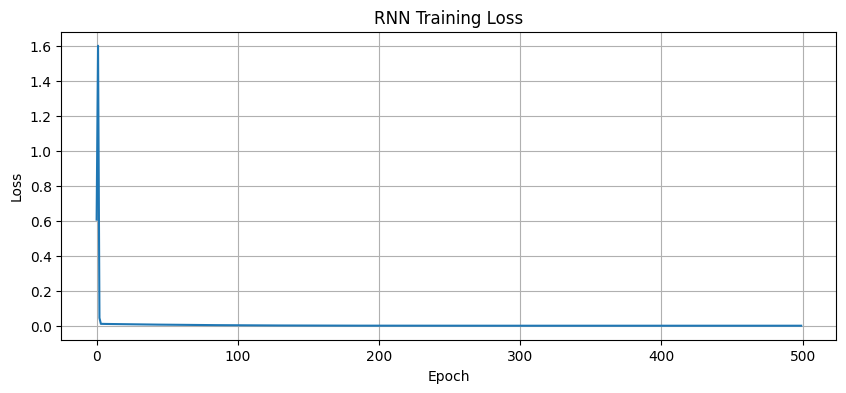

In [10]:
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('RNN Training Loss')
plt.grid(True)
plt.show()

In [11]:
print("Predictions on Training Data:")
print("="*60)
print(f"{'Sequence':<25} {'Target':<10} {'Predicted':<10} {'Error':<10}")
print("-"*60)

for i in range(len(X_sequences)):
    y_pred, _, _ = rnn_forward(X_sequences[i], W_xh, W_hh, b_h, W_hy, b_y)
    seq = [x.item() for x in X_sequences[i]]
    target = y_targets[i].item()
    pred = y_pred.item()
    error = abs(target - pred)
    print(f"{str(seq):<25} {target:<10.4f} {pred:<10.4f} {error:<10.4f}")

print("\n✓ RNN has learned to predict the next number in the sequence!")

Predictions on Training Data:
Sequence                  Target     Predicted  Error     
------------------------------------------------------------
[0.10000000149011612, 0.20000000298023224, 0.30000001192092896] 0.4000     0.4009     0.0009    
[0.20000000298023224, 0.30000001192092896, 0.4000000059604645] 0.5000     0.4993     0.0007    
[0.30000001192092896, 0.4000000059604645, 0.5] 0.6000     0.5998     0.0002    
[0.4000000059604645, 0.5, 0.6000000238418579] 0.7000     0.7001     0.0001    

✓ RNN has learned to predict the next number in the sequence!


In [12]:
# Test on new sequences
X_test = torch.tensor([
    [[0.5], [0.6], [0.7]],  # Should predict ~0.8
    [[0.1], [0.2], [0.3]],  # Should predict ~0.4
], dtype=torch.float32)

print("Predictions on New Sequences:")
print("="*50)

for i in range(len(X_test)):
    y_pred, _, _ = rnn_forward(X_test[i], W_xh, W_hh, b_h, W_hy, b_y)
    seq = [x.item() for x in X_test[i]]
    print(f"Sequence: {seq} → Predicted: {y_pred.item():.4f}")

Predictions on New Sequences:
Sequence: [0.5, 0.6000000238418579, 0.699999988079071] → Predicted: 0.7983
Sequence: [0.10000000149011612, 0.20000000298023224, 0.30000001192092896] → Predicted: 0.4009


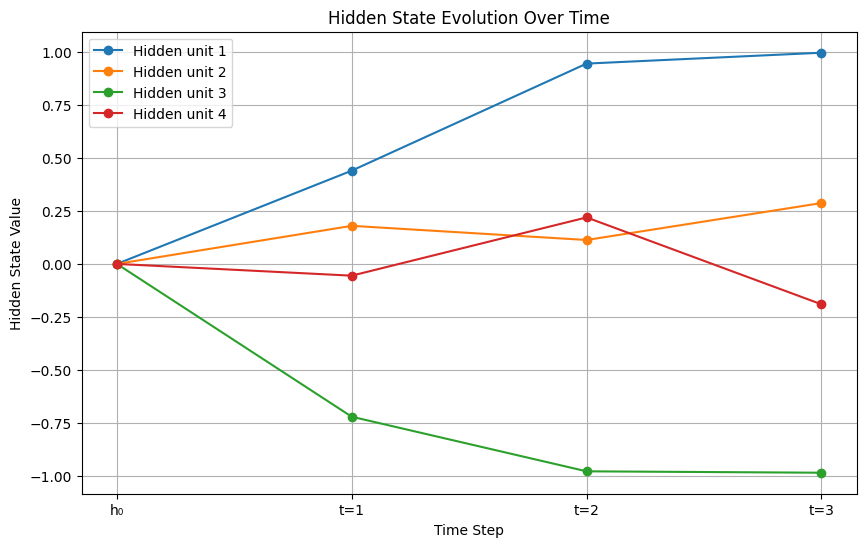

In [13]:
# Visualize how hidden state evolves through time for one sequence
_, hidden_states, _ = rnn_forward(X_sequences[0], W_xh, W_hh, b_h, W_hy, b_y)

# Convert to numpy for plotting
hidden_array = torch.stack(hidden_states).squeeze().numpy()

plt.figure(figsize=(10, 6))
for i in range(hidden_size):
    plt.plot(hidden_array[:, i], marker='o', label=f'Hidden unit {i+1}')

plt.xlabel('Time Step')
plt.ylabel('Hidden State Value')
plt.title('Hidden State Evolution Over Time')
plt.xticks(range(len(hidden_states)), ['h₀'] + [f't={i+1}' for i in range(len(hidden_states)-1)])
plt.legend()
plt.grid(True)
plt.show()